Notebook para agrupar técnicas de otimização hiperparamétrica seguindo o seguinte artigo:

https://www.kaggle.com/pavansanagapati/automated-hyperparameter-tuning

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [12]:
# importando dataset
df = pd.read_csv('Datasets/Credit_card.csv',na_values = '#NAME?')

#Separando variáveis dependentes e independentes
X = df[['V17', 'V9', 'V6', 'V12']]
y = df['Class']

#Separando dados de treino e teste
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.30,random_state = 101)

In [15]:
#o modelo base será Random Forest Classifier

#criando, treinando e armazenando predições do modelo
model = RandomForestClassifier(random_state= 101).fit(X_Train,y_Train)
predictionforest = model.predict(X_Test)

# Mostrando confusion matrix para análise dos resultados
print(confusion_matrix(y_Test,predictionforest))

#armazenando acurácia
acc1 = accuracy_score(y_Test,predictionforest)

[[85289    10]
 [   34   110]]


##### Grid Search

In [17]:
#Definindo grade de hiperparâmetros
grid_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

#Criando random forest
clf = RandomForestClassifier()

#aplicando busca em grade e armazenando os melhores hp no novo modelo e treinando o novo modelo
model = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 5, verbose= 5, n_jobs = -1)
model.fit(X_Train,y_Train)

#armazenando predições
predictionforest = model.best_estimator_.predict(X_Test)

#printando confusion matrix
print(confusion_matrix(y_Test,predictionforest))

#armazenando acurácia
acc_grid = accuracy_score(y_Test,predictionforest)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.9min finished


[[85279    20]
 [   44   100]]


##### Random search

In [20]:
#Definindo grade de hiperparâmetros
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}

#aplicando busca aleatória e armazenando os melhores hp no novo modelo e treinando o novo modelo
clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, cv = 5, verbose= 1, 
                           random_state= 101, n_jobs = -1)

#Treinando modelo ajustado
model.fit(X_Train,y_Train)

#armazenando predições
predictionforest = model.best_estimator_.predict(X_Test)

#printando confusion matrix
print(confusion_matrix(y_Test,predictionforest))

#armazenando acurácia
acc_random = accuracy_score(y_Test,predictionforest)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


[[85280    19]
 [   44   100]]


##### Bayesian

In [26]:
#Criando espaço de hiperparâmetros
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 12, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50])
    }

# definindo função objetivo, será o modelo Random Forest com os hiperparâmetros do espaço amostral
# o valor a ser maximizado é a acurácia do modelo, como o algoritmo de busca bayesiana minimiza o resultado, é passado o inverso
# da acurácia
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                   max_features = space['max_features'],
                                   min_samples_leaf = space['min_samples_leaf'],
                                   min_samples_split = space['min_samples_split'],
                                   n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_Train, y_Train, cv = 5).mean()

    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()

#Chamando função para otimizar os hp
best = fmin(fn= objective, space= space, algo= tpe.suggest, max_evals = 20, trials= trials)
best

100%|███████████████████████████████████████████████| 20/20 [04:00<00:00, 12.04s/trial, best loss: -0.9982544492235963]


{'criterion': 1,
 'max_depth': 10.0,
 'max_features': 2,
 'min_samples_leaf': 0.42623733370143474,
 'min_samples_split': 0.2165250363584751,
 'n_estimators': 1}

In [24]:
print(hp.quniform('max_depth', 10, 12, 10))

0 float
1   hyperopt_param
2     Literal{max_depth}
3     uniform
4       Literal{10}
5       Literal{12}
6       Literal{10}


In [28]:
#Criando dicionário para converter retorno do função de otimização
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 75, 3: 100, 4: 125}

#treinando Random Forest com os melhores valores
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X_Train,y_Train)
#Armazenando predições
predictionforest = trainedforest.predict(X_Test)

#Printando confusion matrix
print(confusion_matrix(y_Test,predictionforest))

#armazenando acurácia
acc_bayesian = accuracy_score(y_Test,predictionforest)

[[85299     0]
 [  144     0]]


##### Genetic Algorithms

In [34]:
#Definindo hiperparâmetros
parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto'],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': [10]}
            
#Invocando classificador genético
tpot_classifier = TPOTClassifier(generations= 4, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 5, scoring = 'accuracy')

#treinando classificador
tpot_classifier.fit(X_Train,y_Train) 

#Armazenando predições
predictiongenetic = tpot_classifier.predict(X_Test)

#Printando confusion matrix
print(confusion_matrix(y_Test,predictiongenetic))

#Armazenando acurácia
acc_ga = tpot_classifier.score(X_Test, y_Test)

[[85279    20]
 [   36   108]]


Gráfico das acurácias

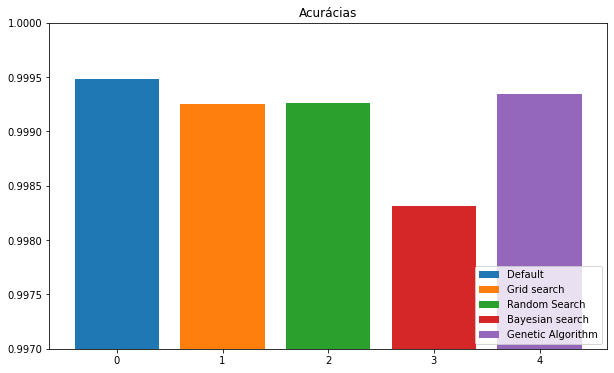

In [45]:
plt.figure(figsize=(10,6))
plt.title("Acurácias")
plt.bar(0, acc1, label='Default')
plt.bar(1, acc_grid, label='Grid search')
plt.bar(2, acc_random, label='Random Search')
plt.bar(3, acc_bayesian, label='Bayesian search')
plt.bar(4, acc_ga, label='Genetic Algorithm')
plt.ylim(0.997,1.0)
plt.legend(loc='lower right')
plt.show()